In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.signal import argrelextrema
%matplotlib inline

In [2]:
data = np.load("data/DK_time_series_3000000.npy")

train = data[:-500000]
test =  data[-500000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [3]:
Hs = mean + 4 * std

In [4]:
lstm_predicts = []
for i in range(19):
    lstm_predicts.append(np.load("predicts/lstm_predict_" + str(i) + ".npy"))

In [5]:
def Calc_TP(predict, target, k, n, m):

    assert len(predict) == len(target)

    TP = 0
    i = n
    TP_lst = []
    while i < len(predict):
        if predict[i] > Hs:
            if (target[i - k + 1: i + n] > Hs).any() and (test[i-m: i - k + 1] < Hs).all():
                #print(i)
                TP_lst.append(i)
                i += n
                TP += 1
        i += 1
    return TP, TP_lst

In [6]:
test_right_part = (len(test)- 20)%64
TP = Calc_TP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
TP

766

In [7]:
test_right_part = (len(test)- 20)%64
TP = Calc_TP(lstm_predicts[1][:-1], test[21:-test_right_part], 2, 50, 7)
TP

711

In [8]:
TP = Calc_TP(lstm_predicts[2][:-2], test[22:-test_right_part], 3, 50, 10)
TP

405

In [6]:
wave_net_predicts = np.load("predicts/wavenet_predict_all_steps.npy")

In [7]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans     

In [9]:
lstm_predicts[0]

array([-0.60564967,  0.09434186,  1.01936623, ..., -1.72870774,
       -1.60470045, -1.43263915])

In [ ]:
test_right_part = (len(test)- 20)%64
TPs_lstm = []
TPs_wave = []
for i in range(19):
    TP_wave, _ = Calc_TP(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1], test[1:], 1, 50, 5 + i)
    TPs_wave.append(TP_wave)
    if i:
        TP_lstm, _ = Calc_TP(lstm_predicts[i][:-i], test[20+i:-test_right_part], i+1, 50, 5 + i)
        TPs_lstm.append(TP_lstm)
    else:
        TP_lstm, _ = Calc_TP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
        TPs_lstm.append(TP_lstm)
    

In [101]:
TP = Calc_TP(int_to_amp(wave_net_predicts[:, 1:][0], data, n=256)[:-1], test[1:], 1, 50, 5)
TP

157

In [102]:
TP = Calc_TP(int_to_amp(wave_net_predicts[:, 1:][1], data, n=256)[:-2], test[2:], 2, 50, 7)
TP

66

In [103]:
TP = Calc_TP(int_to_amp(wave_net_predicts[:, 1:][2], data, n=256)[:-3], test[3:], 3, 50, 10)
TP

10

In [63]:
(test > Hs).sum()

833

In [56]:
(test[19987:] > Hs).argmax() + 19986

30969

In [46]:
test[3:][4040:4050]

2.763562053982881

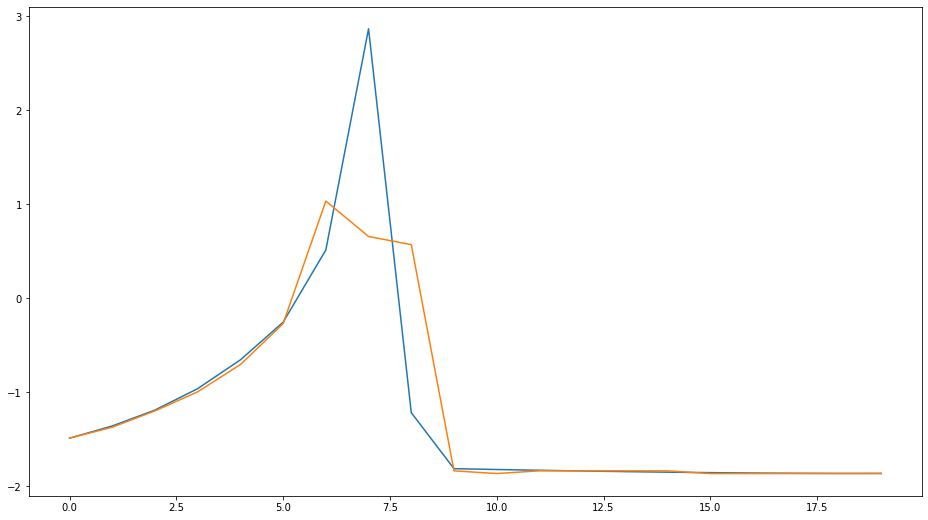

In [57]:
plt.figure(figsize=(16, 9))

wavenet_pred_3 = int_to_amp(wave_net_predicts[:, 1:][2], data, n=256)[:-3]
plt.plot(test[3:][30960:30980])
plt.plot(wavenet_pred_3[30960:30980])

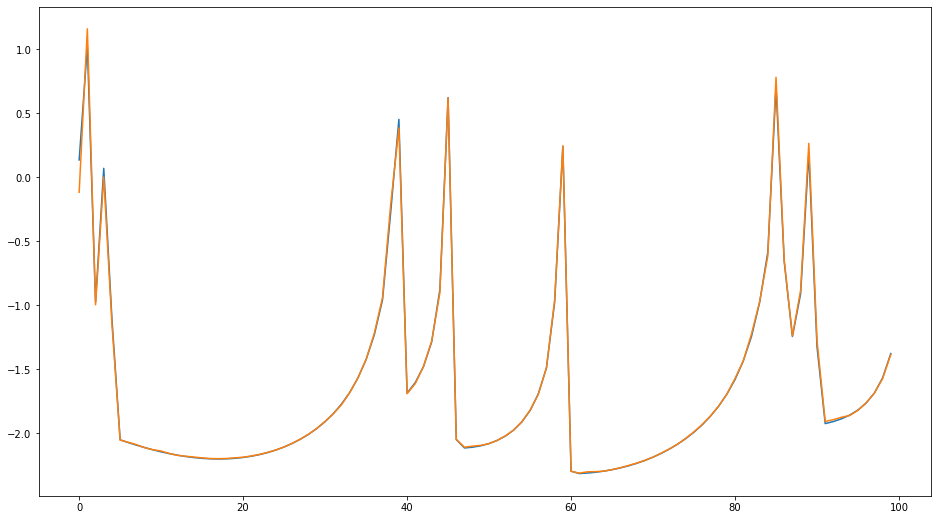

In [17]:
target = test[21:-test_right_part]

plt.figure(figsize=(16, 9))
plt.plot(target[:100])
plt.plot(lstm_predicts[1][:100])

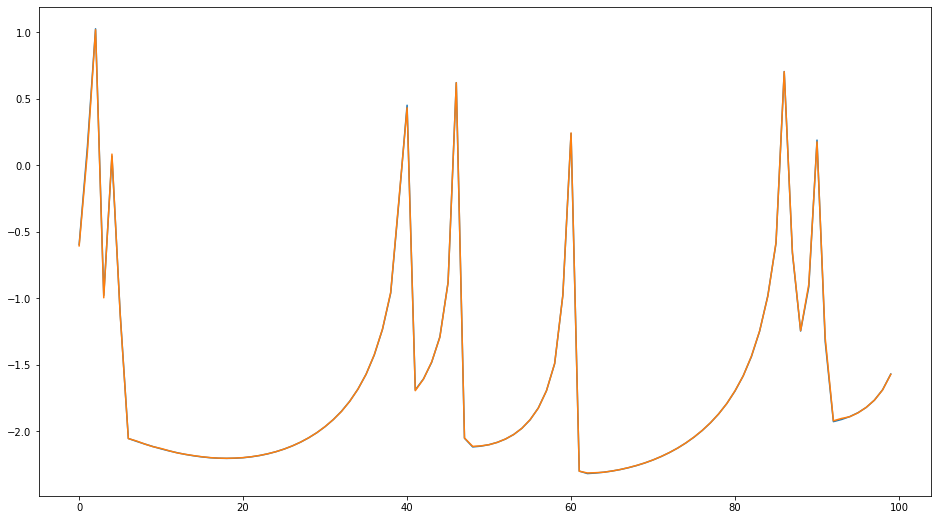

In [12]:
target = test[20:-test_right_part]

plt.figure(figsize=(16, 9))
plt.plot(target[:100])
plt.plot(lstm_predicts[0][:100])

In [22]:
def Calc_FN(predict, target, k, n, m):

    assert len(predict) == len(target)

    FN = 0
    i = n
    FN_lst = []
    while i < len(predict):
        if target[i] > Hs:
            if (predict[i - n: i + k] < Hs).all():
                #print(i)
                #return FN
                FN_lst.append(i)
                i += n
                FN += 1
        i += 1
    return FN, FN_lst

In [10]:
Hs = mean + 4 * std

In [11]:
TP = Calc_TP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
FN = Calc_FN(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
#assert TP + FN == (test > Hs).sum()

In [12]:
TP = Calc_TP(lstm_predicts[1][:-1], test[21:-test_right_part], 2, 50, 5)
FN = Calc_FN(lstm_predicts[1][:-1], test[21:-test_right_part], 2, 50, 5)
#assert TP + FN == (test > Hs).sum()

In [24]:
TP, TP_lst = Calc_TP(lstm_predicts[2][:-2], test[22:-test_right_part], 3, 50, 5)
FN, FN_lst = Calc_FN(lstm_predicts[2][:-2], test[22:-test_right_part], 3, 50, 5)
#assert TP + FN == (test > Hs).sum()

In [14]:
TP

405

In [17]:
def OnlyPeaks(time_series):
    spikes_ind = argrelextrema(time_series, np.greater) 
    spikes = time_series[spikes_ind]
    return spikes

In [18]:
(OnlyPeaks(test) > Hs).sum()

785

In [27]:
TP + FN

774

In [52]:
FN

369

In [25]:
All_picks = TP_lst + FN_lst

In [33]:
len(All_picks)

774

In [40]:
true_picks = [i for i in range(len(test[22:-test_right_part])) if (test[22:-test_right_part][i] > Hs)]

In [41]:
dif = set(true_picks).difference(set(All_picks))

In [42]:
len(dif)

106

In [61]:
list(dif)[0]

100354

In [62]:
test[22:-test_right_part][100354]

1.7218634650882372

In [64]:
lstm_predicts[2][:-2][100353]

1.185853752424743

In [50]:
Hs

1.0722118587496372

In [58]:
385026 in TP_lst

True

In [67]:
lstm_predicts[2][:-2][100354-2:100354 + 10] < Hs

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [68]:
((lstm_predicts[2][:-2][100354-2:100354 + 10]) < Hs).all()
    

False

In [69]:
for ind in list(dif):
    if ((lstm_predicts[2][:-2][ind-2:ind + 10]) < Hs).all():
        print(ind)

180233
92209
99399
109131
109132
207492
84689
52959
130273
316146
52979
32538
288539
255784
176469
44479
471493
48587
443345
356849
165363


In [71]:
92209 in FN_lst

False

In [72]:
FN_lst

[1284,
 2008,
 4178,
 8738,
 9183,
 9692,
 11030,
 12023,
 12387,
 13754,
 14363,
 15220,
 15674,
 17219,
 19964,
 21404,
 22335,
 22813,
 24366,
 24655,
 25093,
 25404,
 26096,
 30948,
 31197,
 31303,
 31611,
 34386,
 36927,
 37345,
 37512,
 38733,
 40333,
 44437,
 44556,
 46068,
 48586,
 48951,
 51346,
 52958,
 53412,
 55331,
 56894,
 58682,
 59246,
 59430,
 63982,
 64920,
 65338,
 65514,
 66849,
 67618,
 70162,
 75660,
 78739,
 78931,
 79369,
 81240,
 81903,
 84688,
 84914,
 85997,
 88042,
 89295,
 92208,
 93510,
 93589,
 94597,
 94834,
 95226,
 96247,
 96854,
 97765,
 98857,
 99398,
 100061,
 103487,
 106233,
 112850,
 113217,
 117434,
 117996,
 118386,
 119325,
 120556,
 121637,
 122109,
 129675,
 130272,
 131523,
 132433,
 134174,
 135552,
 137981,
 138412,
 139245,
 140003,
 140677,
 142498,
 142897,
 143066,
 143432,
 143550,
 143824,
 144289,
 146811,
 147140,
 147718,
 148316,
 148738,
 149618,
 150998,
 151323,
 155040,
 155792,
 156388,
 158764,
 158926,
 162705,
 163651,
 

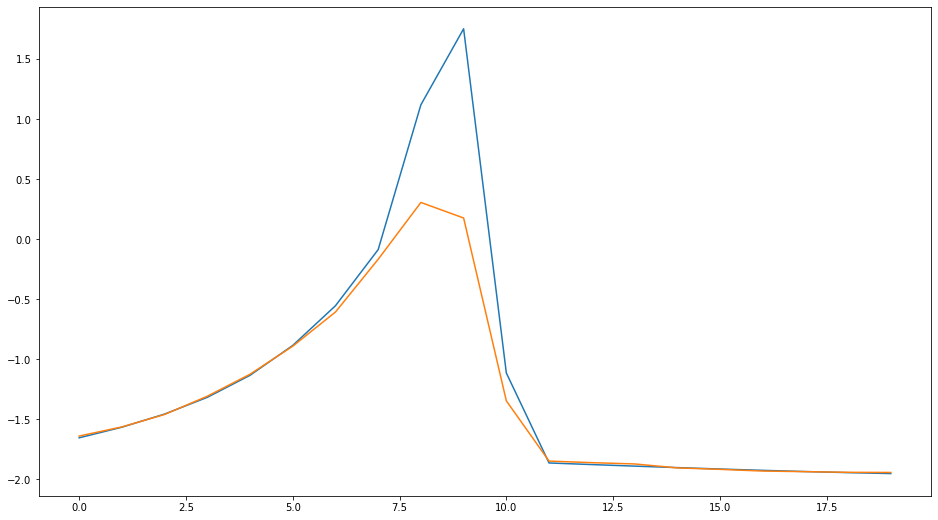

In [70]:
plt.figure(figsize=(16, 9))
plt.plot(test[22:-test_right_part][92200: 92220])
plt.plot(lstm_predicts[2][:-2][92200: 92220])

In [43]:
len(true_picks) - len(All_picks)

59

In [89]:
FN

6

In [83]:
Hs

1.0722118587496372

In [84]:
target[1286]

1.1384990915406354

In [85]:
lstm_predicts[0][1286]

1.139992045143501

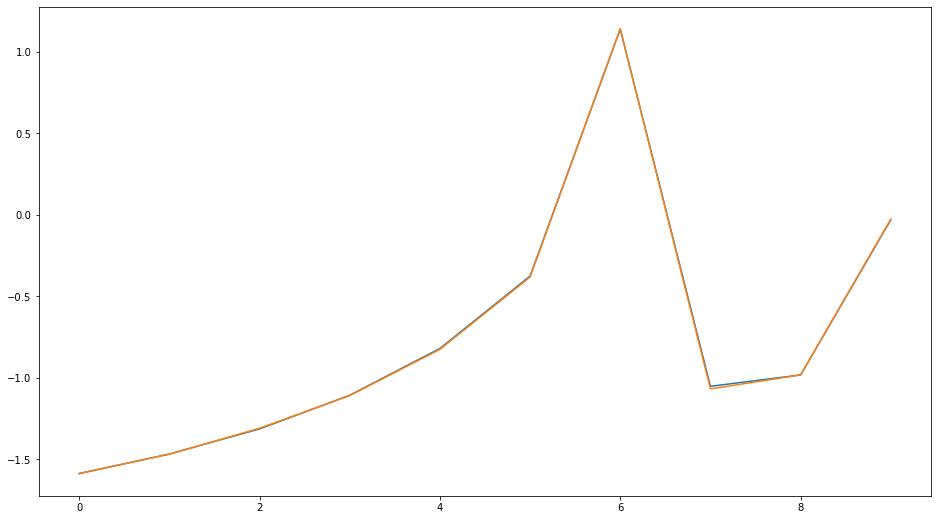

In [81]:
target = test[20:-test_right_part]

plt.figure(figsize=(16, 9))
plt.plot(target[1280:1290])
plt.plot(lstm_predicts[0][1280:1290])